# EEE 443 - Final Project - Image Captioning

## Group 12:

Atakan Topcu, Ata Korkusuz, Ata Yavuzyılmaz, Dora Tütüncü

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [283]:
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import h5py
import seaborn as sn
import requests
from PIL import Image
import os 
import requests
import pandas as pd
file_train="eee443_project_dataset_train.h5"
file_test="eee443_project_dataset_test.h5"


### Next Step:
We first create function to read from the given h5 file.

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [275]:
def Dataset_Read(file_train):
    '''
    Funtction to read given h5 train file
    '''
    f = h5py.File(file_train, 'r') #Load Data
    print("Keys: %s" % list(f.keys()))
    train_cap = f['train_cap'][()] #Captions for training images (contains 17 indices from the vocabulary for each image
    train_imid = f['train_imid'][()] #The indices of training images (since a single image can be captioned several times
    train_url = f['train_url'][()] #Flickr URLs for training images 
    word_code = f['word_code'][()] #Dictionary for converting words to vocabulary indices
    train_ims = None  #Do not use train_ims. Otherwise, score is halved!!
    print("Size of captions: ",train_cap.shape)
    print("Size of indices of training images: ",train_imid.shape[0])
    print("Size of URL: ",train_url.shape[0])
    print("Size of Dictionary: ",word_code.shape[0])
    return train_imid, train_cap, train_url, word_code

def Test_Read(file_test):
    '''
    Funtction to read given h5 test file
    '''
    f = h5py.File(file_test, 'r') #Load Data
    print("Keys: %s" % list(f.keys()))
    test_caps = f['test_caps'][()] #Captions for test images (contains 17 indices from the vocabulary for each image
    test_imid = f['test_imid'][()] #The indices of test images (since a single image can be captioned several times
    test_url = f['test_url'][()] #Flickr URLs for test images
    test_ims = None  #Do not use test_ims. Otherwise, score is halved!!
    print("Size of captions: ", test_caps.shape)
    print("Size of indices of test images: ", test_imid.shape[0])
    print("Size of URL: ", test_url.shape[0])
    return test_imid, test_caps, test_url

### Next Step:
We create a new directory for downloading the images from the Flickr URL addresses. Also verification method is implemented. We look at two factors for images that will be used in the project:

1. HTTP Status Code (Needs to be 200)
2. JPEG Format


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [297]:
#root_dir = os.getcwd()
direc='C:\\Users\\ataka\\Desktop\\EEE443_Proje' #Change accordingly
imgs_dir = direc + '\\Downloaded_Ims'
exports_dir = direc + '\\Exported_Ims'
testNEW=direc + '\\testNEW'
from tqdm.notebook import tqdm #For progress bar representation. Purely decoration purposes!
os.chdir('C:\\Users\\ataka\\Desktop\\EEE443_Proje')#Change accordingly
_, _, test_url=Test_Read(file_test)
def Download(directory,URLa):
    """
    Function to save images from given urls
    """
    os.chdir('C:\\Users\\ataka\\Desktop\\EEE443_Proje')#Change accordingly
    train_imid,train_cap,URL,word_code=Dataset_Read(file_train)
    if not os.path.exists(directory): #Create the directory if it does not exist in the first place.
        os.makedirs(directory)
    os.chdir(directory)
    print('Current working directory: ', os.getcwd()) #Check
    
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:95.0) Gecko/20100101 Firefox/95.0'}#Change accordingly
    for URL in tqdm(range(6686,len(URLa))):
        url = URLa[URL].decode('utf-8')
        response = requests.get(url, allow_redirects=True, stream=True, headers=headers)
        #If HTTP 200 is achieved, write file
        if response.status_code == 200:
            with open(directory+ '/' + str(URL), 'wb') as outfile:
                    outfile.write(response.content)
    
    os.chdir('..')
    print('Current working directory: ', os.getcwd())#Check     

    return 

Keys: ['test_caps', 'test_imid', 'test_ims', 'test_url']
Size of captions:  (195954, 17)
Size of indices of test images:  195954
Size of URL:  40504


In [299]:
#Download(testNEW,test_url)

In [277]:
def Image_Verification(directory,train_url):
    os.chdir('C:\\Users\\ataka\\Desktop\\EEE443_Proje')#Change accordingly
    os.chdir(directory)
    corrupt_index = []
    d_index=[]
    print('Current working directory: ', os.getcwd()) #Check
    for URL in range(len(train_url)):
        try:
            img = Image.open(directory + '/' + str(URL))
            if img.format == 'JPEG':
                continue
            else:
                print('Invalid image type, not JPEG')
                corrupt_index.append(directory + '\\' + str(URL))
                d_index.append(URL)
        except:
            continue
    os.chdir('..')
    print('Current working directory: ', os.getcwd())#Check  
    # Take note of the problematic image files
    with open('D_Ims.txt', 'w') as txt_file:
        for items in corrupt_index:
            txt_file.write('%s\n' % items)
    return d_index

In [278]:
os.getcwd()

'C:\\Users\\ataka\\Desktop\\EEE443_Proje\\Exported_Ims'

In [279]:
#os.chdir('/content/drive/MyDrive/EE443 Project')
os.chdir(direc)
train_imid,train_cap,train_url,word_code=Dataset_Read(file_train)
#Del_index=Image_Verification(imgs_dir,train_url)

Keys: ['train_cap', 'train_imid', 'train_ims', 'train_url', 'word_code']
Size of captions:  (400135, 17)
Size of indices of training images:  400135
Size of URL:  82783
Size of Dictionary:  1


### Next Step:

We start implementing the transfer model. In our case, we will be using Inception Resnet V2. Other models can also be used such as Inception v3 or VGGA16. In order to extract features using such models, consider two factors:

1. Input Size: Input size must be (255,255,3) for the Inception Resnet V2 model. Thus, you have to preprocess your images.
2. Get rid of the final layer in your model. We want the pre-Trained Model as Feature Extractor Preprocessor. Thus, you have to get rid of the last layer as it is used for the original classification task.

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [280]:
import tensorflow as tf
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input 
from tensorflow.keras.preprocessing import image 


"""
Target Model:

            InceptionResNetV2(
                include_top=True, weights='imagenet', input_tensor=None,
                input_shape=None, pooling=None, classes=1000,
                classifier_activation='softmax', **kwargs
            )
"""

#If time allows different methods can also be utilized such as VGG16.    
def Feature_Extraction_Model(): 
    tf.keras.backend.clear_session() # clears previous session if this code is run multiple time
    #Pre-Trained Model as Feature Extractor Preprocessor
    ResNet = InceptionResNetV2(include_top=True, weights='imagenet', input_shape=(299,299,3))
    ResNet.trainable = False
    ResNet = tf.keras.Model(ResNet.input, ResNet.layers[-2].output)# remove the output layer
    return ResNet

def ImageEncoding(directory, imageIndex,model):
    #Process images so that they can be inputted in the model correctly.
    img = tf.io.read_file(directory+imageIndex)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.expand_dims(img, axis=0)
    #print(img.shape)
    img = preprocess_input(img)
    encoding = model.predict(img) #Extracts features into single 2D vector.
    #print(encoding.shape) 
    return encoding    #Should be of size (1,1536)


### Next Step:

In this step, we define the final function for creating the encoded features using our transfer model. There are three factors to consider:

1. Problematic Files: Previously, we have defined problematic non-JPEG files in a .txt file of our main directory. Before you start encoding, you have to make sure these files are not used in the process for the sake of performance and reliability.

2. Iteratively, you will go through each file in the train directory and start encoding. You will return a list called Encoded_Features which will be used in future.

3. ***Never stack model:*** This is extremely important. You should define the model outside of the Create_Features function. Otherwise, it will stack up in the for loop and it will take significant time (days) to compile the images.

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [281]:
from tqdm import tqdm
def Create_Features(directory,model):
    #os.chdir('C:\\Users\\ataka\\Desktop\\EEE443_Proje')#Change accordingly
    txt_file=open('D_Ims.txt', 'r') #If you named the .txt file differently, change accordingly.
    Problem_files=txt_file.readlines()#Read the problematic file names.
    
    os.chdir(directory) #Change to training directory!
    print(os.getcwd())#Check
    Encoded_Features = []
    for img in tqdm(os.listdir()): #Scans the directory. img is a string!
        check=os.getcwd()+'\\'+img+'\n'
        if not Problem_files.count(check): 
            tmp = ImageEncoding(os.getcwd()+ '\\',img, model)
            Encoded_Features.append(tmp)
        else:
            print("Warning:non_JPEG format detected. It will not be used!")

    Encoded_Features=np.array(Encoded_Features)
    Encoded_Features=Encoded_Features.reshape(Encoded_Features.shape[0],Encoded_Features.shape[2])
    return Encoded_Features #Should output (x,1536) where x is the number of samples.



In [8]:
os.getcwd()

'C:\\Users\\ataka\\Desktop\\EEE443_Proje'

### Next Step:

We don't want to start this encoding process over and over as it will take time. Thus, save it as pickle file and load it later when needed.

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [187]:
import pickle #Call the function


In [ ]:
os.chdir(imgs_dir)
Index=[]
for img in tqdm(os.listdir()): #Scans the directory. img is a string!
        check=os.getcwd()+'\\'+img+'\n'
        if not Problem_files.count(check): 
            Index.append(img)

NameError: ignored

In [ ]:
print('Encoding finished. Pickling.')
if not os.path.exists(exports_dir): #Create the directory if it does not exist in the first place.
        os.makedirs(exports_dir)
os.chdir(exports_dir)

# save to file
print(Encoded_Features.shape)
pickle.dump(Encoded_Features, open('Feature_Encodes.pkl', 'wb'))
pickle.dump(Index, open('Feature_Index.pkl', 'wb'))


os.chdir(direc) # return back to the main directory

### Check GPU Availability:

Tensorflow might cause problem in enabling GPU usage since it requires many packages to be downloaded (CUDA, cuDNN, etc.). Thus, I recommend using Google Collab as it eases this operation. If you are not using Google Collab, you should check the compability of cuDNN and CUDA first as the newest vesions are not backwards compatible

**Collab --->Edit ---> Notebook Settings ---> Hardware Accelerator ---> GPU ---> Save**

For Local Jupyter Application, follow the link for setting up CUDA and cuDNN on your environment path.

https://towardsdatascience.com/installing-tensorflow-with-cuda-cudnn-and-gpu-support-on-windows-10-60693e46e781


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [188]:
print("GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if len(tf.config.list_physical_devices('GPU'))==0:
  print("Warning: Need to Enable GPU")
else:
  print((tf.config.list_physical_devices('GPU')))

#Should enable GPU. Otherwise, project will take time.

GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Load Pickle File Again
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [189]:
import pickle
print(os.getcwd())
os.chdir("Exported_Ims")
print(os.getcwd())
print(os.listdir())

C:\Users\ataka\Desktop\EEE443_Proje
C:\Users\ataka\Desktop\EEE443_Proje\Exported_Ims
['actual_container.pkl', 'Feature_Encodes.pkl', 'Feature_Index.pkl', 'pred_container_v2_trainable_bilstm.pkl', 'Test_Captions.pkl', 'Test_Encodes.pkl', 'TEST_Feature_Encodes.pkl', 'TEST_Feature_Index.pkl', 'Train_Captions.pkl', 'Train_Encodes.pkl', 'Validation_Captions.pkl', 'Validation_Encodes.pkl']


In [ ]:
Feature_Encodes = pickle.load(open(exports_dir + "\\Feature_Encodes.pkl",'rb'), encoding='utf8')
Feature_Index = pickle.load(open(exports_dir + "\\Feature_Index.pkl",'rb'), encoding='utf8')
print(Feature_Encodes.shape)
Feature_Index=np.array(Feature_Index)
print(Feature_Index.shape)

(71648, 1536)
(71648,)


### Extract Word Dictionary Along with Creating Functions for Captioning
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [190]:
#Export Word Dictionary. Size should be 1004!
os.chdir(direc)
_,_,_,word_code=Dataset_Read(file_train)
Words = pd.DataFrame(word_code)
Words = Words.sort_values(0, axis=1)
word_columns = np.asarray(Words.columns)
wordDict = {}
for i in range(len(word_columns)):
  word = word_columns[i]
  wordDict[i] = word
print('Size of Extracted Word Dictionary: ', len(wordDict.keys()))


def Caption_string(caption_array):
    """
    Format caption numpy array to a list of string(s).
    """
    
    Captions_list = []
    caption = ""
    for caps in caption_array:
        for word in caps:
            if (word == 'x_NULL_') or (word == 'x_START_') or (word == 'x_END_'):
                continue #Don't count x_NULL, x_Start and x_END
            elif (word == 'x_UNK_'):
                word = 'UNKNOWN'
            caption += word + " "

        Captions_list.append(caption.strip()) #Remove spaces and append
        caption = ""
    return Captions_list


def get_key(val,dictionary): # Function to return key for any value
    for key, value in dictionary.items():
        if val == key:
            return value
             

Keys: ['train_cap', 'train_imid', 'train_ims', 'train_url', 'word_code']
Size of captions:  (400135, 17)
Size of indices of training images:  400135
Size of URL:  82783
Size of Dictionary:  1
Size of Extracted Word Dictionary:  1004


In [191]:
wordDict

{0: 'x_NULL_',
 1: 'x_START_',
 2: 'x_END_',
 3: 'x_UNK_',
 4: 'a',
 5: 'on',
 6: 'of',
 7: 'the',
 8: 'in',
 9: 'with',
 10: 'and',
 11: 'is',
 12: 'man',
 13: 'to',
 14: 'sitting',
 15: 'an',
 16: 'two',
 17: 'standing',
 18: 'at',
 19: 'people',
 20: 'are',
 21: 'next',
 22: 'white',
 23: 'woman',
 24: 'table',
 25: 'street',
 26: 'that',
 27: 'holding',
 28: 'person',
 29: 'large',
 30: 'some',
 31: 'it',
 32: 'down',
 33: 'top',
 34: 'group',
 35: 'field',
 36: 'up',
 37: 'small',
 38: 'near',
 39: 'tennis',
 40: 'his',
 41: 'front',
 42: 'black',
 43: 'plate',
 44: 'room',
 45: 'train',
 46: 'riding',
 47: 'dog',
 48: 'red',
 49: 'young',
 50: 'by',
 51: 'cat',
 52: 'water',
 53: 'baseball',
 54: 'has',
 55: 'xWhile',
 56: 'walking',
 57: 'playing',
 58: 'bathroom',
 59: 'sign',
 60: 'blue',
 61: 'food',
 62: 'kitchen',
 63: 'grass',
 64: 'bus',
 65: 'there',
 66: 'parked',
 67: 'pizza',
 68: 'green',
 69: 'side',
 70: 'other',
 71: 'building',
 72: 'looking',
 73: 'snow',
 74: '

In [ ]:
import pickle

pickle.dump(wordDict, open("ixtoword.pkl", 'wb'))

In [192]:
os.getcwd()

'C:\\Users\\ataka\\Desktop\\EEE443_Proje'

In [193]:
def Fetch_Caption(image_id, imid, cap, word_dict):
    """
    A function which returns the caption of an image wrt. its ID
    """
    # Query this on train_imid to extract which indices hold the captions for this image:
    indices = np.where(imid == int(image_id))[0] #[0] removes tuple's second element which is dtype=int64
    caps = [] #Extract the caps of the specified image
    for idx in indices:
        cap1 = cap[idx][:]
        caps.append(cap1)
    #Conversion to string
    text_cap = []
    for item in caps:
        temp = []
        for word in item:
            key=get_key(word,word_dict) # Function to return key for any value
            temp.append(key)
        text_cap.append(temp)
       
    caps = [list(c) for c in caps] # list comprehension to make arrays list
    '''
    Should return something like:
    [[1, 7, 78, 240, 20, 244, 5, 7, 213, 35, 2, 0, 0, 0, 0, 0, 0], [1, 78, 240, 6, 193, 927, 244, 5, 63, 2, 0, 0, 0, 0, 0, 0, 0], [1, 30, 240, 20, 244, 5, 3, 10, 536, 3, 542, 2, 0, 0, 0, 0, 0], [1, 4, 423, 240, 244, 10, 109, 63, 8, 4, 35, 2, 0, 0, 0, 0, 0], [1, 78, 193, 3, 240, 244, 5, 7, 63, 2, 0, 0, 0, 0, 0, 0, 0]]
    '''
    return caps

# Print captions of an image
def Caption_Print(caps, word_dict):
    i = 0
    text_cap = []
    
    for item in caps:
        i += 1
        temp = []
        for word in item:
            key=get_key(word,word_dict)
            temp.append(key)
        text_cap.append(temp)
        # x_NULL_ strings are only ignored, not erased from the captions
    Captions_list = Caption_string(text_cap)
    for caption in range(i):
        print('Caption ', caption+1,': ',Captions_list[caption])
    return Captions_list

# !Important!

**For training data, train index yields the train index-1 image**. So, if the index is 314, the train image should be 313!!. 

**For Test data, train index yields the train index image**. So, if the index is 314, the test image should be 314!!. 

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Caption  1 :  the three cows are grazing on the grassy field
Caption  2 :  three cows of different colors grazing on grass
Caption  3 :  some cows are grazing on UNKNOWN and having UNKNOWN time
Caption  4 :  a few cows grazing and eating grass in a field
Caption  5 :  three different UNKNOWN cows grazing on the grass


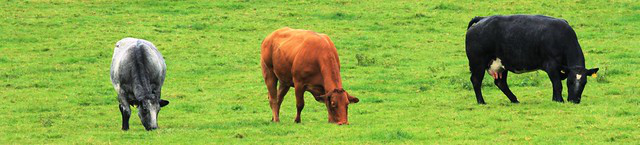

In [194]:
#Example 
cap=Fetch_Caption(314, train_imid, train_cap, wordDict) 
Captions_list = Caption_Print(cap,wordDict)
Image.open(imgs_dir+'\\313') #Careful: We decrement the index given in Fetch_Caption!

### Sub-Divide the Training Data:
Divide your training data as 85% Training and 15% Validation data. Function will output two new dictionaries with sorted IDs.

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [195]:
import random
import math
Feature_Dictionary= dict(zip(Feature_Index, Feature_Encodes)) #We create dictionary from the encoded files (index,features)
def SubDivision(percentage, list_to_divide):
    indices = random.sample(list(list_to_divide.keys()), len(list_to_divide)- math.ceil((1-percentage)*len(list_to_divide)))
    Validation = {}
    Train = {}
    results = list(map(int, indices)) #Convert From String to Int for sorting
    OG=list(map(int, list_to_divide.keys()))
    results.sort(reverse=False) #Ascending Order
    rest=list(set(OG).difference(set(results)))
    rest.sort(reverse=False)
    for idx in results:
            Train[str(idx)]=(list_to_divide[str(idx)])
            
    for idv in rest:
            Validation[str(idv)]=(list_to_divide[str(idv)])
    
    return Validation, Train


NameError: name 'Feature_Index' is not defined

In [ ]:
TRAIN_PERCENTAGE = 0.85
Validation, Train=SubDivision(TRAIN_PERCENTAGE, Feature_Dictionary)
print('Length of the Train Data:',len(Train))
print('Length of the Validation Data:',len(Validation))

Length of the Train Data: 60900
Length of the Validation Data: 10748


### Prepare the input data:

Each key with train, validation data contains keys for encoding dictionary. Each key in the encoding corresponds to a single encoded image, and each encoded image corresponds to approximately 4-5 captions.


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [196]:
from tqdm.notebook import tqdm #For progress bar representation. Purely decoration purposes!
#from tqdm import tqdm #For progress bar representation

#With this dataset, we will call our previous functions for captioning.
def DataPreparation(imid, cap, KEY_Lists,  encoding_dict , word_dict):
    ENCODES = []
    CAPTIONS = []
    for key in tqdm(list(KEY_Lists.keys())): # Iteration for each key in train or validation (Could also be test dataset)
        key_captions = Fetch_Caption(key, imid, cap, word_dict)
        # Replicate encoding number of caption times.
        for i in range(len(key_captions)):
            ENCODES.append(encoding_dict[key]) #Iterate for number of captions
        
        # Process the captions:
        for c in key_captions:
            CAPTIONS.append(c)
            
    return ENCODES,CAPTIONS

In [ ]:
Train_Encodes, Train_Captions = DataPreparation(train_imid, train_cap, Train, Feature_Dictionary, wordDict)

  0%|          | 0/60900 [00:00<?, ?it/s]

In [ ]:
Validation_Encodes, Validation_Captions = DataPreparation(train_imid, train_cap, Validation, Feature_Dictionary, wordDict)

  0%|          | 0/10748 [00:00<?, ?it/s]

### Saving the Outputs:
Now that we have processed the train and validation data, we can proceed to save them in pickle file format so that they can be called in the future without any compilation.

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
import pickle #Call the function
os.chdir(exports_dir)
print(os.getcwd())

# save to file
pickle.dump(Train_Encodes, open('Train_Encodes.pkl', 'wb'))
pickle.dump(Train_Captions, open('Train_Captions.pkl', 'wb'))

pickle.dump(Validation_Encodes, open('Validation_Encodes.pkl', 'wb'))
pickle.dump(Validation_Captions, open('Validation_Captions.pkl', 'wb'))


os.chdir(direc) # return back to the main directory

C:\Users\ataka\Desktop\EEE443_Proje\Exported_Ims


In [ ]:
print('Train Encode Shape:',np.array(Train_Encodes).shape)
print('Train Caption Shape:',np.array(Train_Captions).shape)

print('Validation Encode Shape:',np.array(Validation_Encodes).shape)
print('Validation Caption Shape:',np.array(Validation_Captions).shape)


Train Encode Shape: (294425, 1536)
Train Caption Shape: (294425, 17)
Validation Encode Shape: (51908, 1536)
Validation Caption Shape: (51908, 17)


### Load the Data Back Again:
This way, we create checkpoints where a problem occurs we can just load the file instead of compiling.

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [197]:
import pickle #Call the function
import os
#exports_dir = "/content/drive/MyDrive/EE443 Project/Exported_Ims"
os.chdir(exports_dir)
print(os.getcwd())

Train_Encodes = pickle.load(open(exports_dir + "/Train_Encodes.pkl",'rb'), encoding='utf8')
Train_Captions = pickle.load(open(exports_dir + "/Train_Captions.pkl",'rb'), encoding='utf8')
Validation_Encodes = pickle.load(open(exports_dir + "/Validation_Encodes.pkl",'rb'), encoding='utf8')
Validation_Captions = pickle.load(open(exports_dir + "/Validation_Captions.pkl",'rb'), encoding='utf8')


C:\Users\ataka\Desktop\EEE443_Proje\Exported_Ims


In [198]:
Validation_Captions[0]

[1, 4, 62, 9, 4, 24, 10, 30, 287, 2, 0, 0, 0, 0, 0, 0, 0]

In [199]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = [], [], []
    n=0
    vocab_size = len(wordtoix)
    
    while 1:
        for i in range(len(descriptions)):
            n += 1
            
            photo = photos[i]
            seq = descriptions[i]
            for j in range(len(seq)):
                # split into input and output pair
                in_seq, out_seq = seq[:j], seq[j]
                # pad input sequence
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                # encode output sequence
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                # store
                X1.append(photo)
                X2.append(in_seq)
                y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[np.array(X1), np.array(X2)], np.array(y)]
                X1, X2, y = [], [], []
                n=0
    return X1, X2, y

In [200]:
os.getcwd()

'C:\\Users\\ataka\\Desktop\\EEE443_Proje\\Exported_Ims'

In [201]:
os.chdir(direc)
Embedding_Matrix = pickle.load(open("embedding_matrix.pkl",'rb'), encoding='utf8')

In [202]:
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization, GRU, Bidirectional
from keras.layers.merge import add
from keras.models import Model
from keras import Input, layers
from keras import optimizers

def model_lstm(embedding_matrix):
  vocab_size = embedding_matrix.shape[0]
  embed_dim = embedding_matrix.shape[1]
  max_length = 17

  inputs1 = Input(shape=(1536,))
  drop1 = Dropout(0.5)(inputs1)
  drop2 = Dense(256, activation='relu')(drop1)
  inputs2 = Input(shape=(max_length,))
  se1 = Embedding(vocab_size, embed_dim, mask_zero=True, weights=[embedding_matrix], trainable = False)(inputs2)
  se2 = Dropout(0.5)(se1)
  se3 = LSTM(256)(se2)
  decoder1 = add([drop2, se3])
  decoder2 = Dense(256, activation='relu')(decoder1)
  output = Dense(vocab_size, activation='softmax')(decoder2)
  model = Model(inputs=[inputs1, inputs2], outputs=output)
  model.summary()

  return model
model_lstm(Embedding_Matrix)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 17)]         0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 1536)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 17, 200)      200800      ['input_2[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 1536)         0           ['input_1[0][0]']                
                                                                                              

In [203]:
def model_bilstm(embedding_matrix):
  vocab_size = embedding_matrix.shape[0]
  embed_dim = embedding_matrix.shape[1]
  max_length = 17

  inputs1 = Input(shape=(1536,))
  drop1 = Dropout(0.5)(inputs1)
  drop2 = Dense(512, activation='relu')(drop1)
  inputs2 = Input(shape=(max_length,))
  se1 = Embedding(vocab_size, embed_dim, mask_zero=True, weights=[embedding_matrix], trainable = False)(inputs2)
  se2 = Dropout(0.5)(se1)
  # The Bidirectional outputs two sequences: forward and backward. The merge_mode parameter selects what to do with these sequences.
  # currently, the model concatenates the sequences. (concat)
  se3 = Bidirectional(LSTM(256), merge_mode = 'concat')(se2)
  decoder1 = add([drop2, se3])
  decoder2 = Dense(256, activation='relu')(decoder1)
  output = Dense(vocab_size, activation='softmax')(decoder2)
  model = Model(inputs=[inputs1, inputs2], outputs=output)
  model.summary()

  return model
model_bilstm(Embedding_Matrix)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 17)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1536)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 17, 200)      200800      ['input_4[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 1536)         0           ['input_3[0][0]']                
                                                                                            

In [204]:
def model_gru(embedding_matrix):
  vocab_size = embedding_matrix.shape[0]
  embed_dim = embedding_matrix.shape[1]
  max_length = 17

  inputs1 = Input(shape=(1536,))
  drop1 = Dropout(0.5)(inputs1)
  drop2 = Dense(256, activation='relu')(drop1)
  inputs2 = Input(shape=(max_length,))
  se1 = Embedding(vocab_size, embed_dim, mask_zero=True, weights=[embedding_matrix], trainable = False)(inputs2)
  se2 = Dropout(0.5)(se1)
  se3 = GRU(256)(se2)
  decoder1 = add([drop2, se3])
  decoder2 = Dense(256, activation='relu')(decoder1)
  output = Dense(vocab_size, activation='softmax')(decoder2)
  model = Model(inputs=[inputs1, inputs2], outputs=output)
  model.summary()

  return model
model_gru(Embedding_Matrix)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 17)]         0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 1536)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 17, 200)      200800      ['input_6[0][0]']                
                                                                                                  
 dropout_4 (Dropout)            (None, 1536)         0           ['input_5[0][0]']                
                                                                                            

In [205]:
def model_biGru(embedding_matrix):
  vocab_size = embedding_matrix.shape[0]
  embed_dim = embedding_matrix.shape[1]
  max_length = 17

  inputs1 = Input(shape=(1536,))
  drop1 = Dropout(0.5)(inputs1)
  drop2 = Dense(512, activation='relu')(drop1)
  inputs2 = Input(shape=(max_length,))
  se1 = Embedding(vocab_size, embed_dim, mask_zero=True, weights=[embedding_matrix], trainable = False)(inputs2)
  se2 = Dropout(0.5)(se1)
  # The Bidirectional outputs two sequences: forward and backward. The merge_mode parameter selects what to do with these sequences.
  # currently, the model concatenates the sequences. (concat)
  se3 = Bidirectional(GRU(256), merge_mode= 'concat')(se2)
  decoder1 = add([drop2, se3])
  decoder2 = Dense(256, activation='relu')(decoder1)
  output = Dense(vocab_size, activation='softmax')(decoder2)
  model = Model(inputs=[inputs1, inputs2], outputs=output)
  model.summary()

  return model
model_biGru(Embedding_Matrix)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 17)]         0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 1536)]       0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 17, 200)      200800      ['input_8[0][0]']                
                                                                                                  
 dropout_6 (Dropout)            (None, 1536)         0           ['input_7[0][0]']                
                                                                                            

In [206]:
from keras.layers import SimpleRNN

def simpleRNN(embedding_matrix):
  vocab_size = embedding_matrix.shape[0]
  embed_dim = embedding_matrix.shape[1]
  max_length = 17

  inputs1 = Input(shape=(1536,))
  drop1 = Dropout(0.5)(inputs1)
  drop2 = Dense(256, activation='relu')(drop1)
  inputs2 = Input(shape=(max_length,))
  se1 = Embedding(vocab_size, embed_dim, mask_zero=True, weights=[embedding_matrix], trainable = False)(inputs2)
  se2 = Dropout(0.5)(se1)
  se3 = SimpleRNN(256)(se2)
  decoder1 = add([drop2, se3])
  decoder2 = Dense(256, activation='relu')(decoder1)
  output = Dense(vocab_size, activation='softmax')(decoder2)
  model = Model(inputs=[inputs1, inputs2], outputs=output)
  model.summary()

  return model
simpleRNN(Embedding_Matrix)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 17)]         0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 1536)]       0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 17, 200)      200800      ['input_10[0][0]']               
                                                                                                  
 dropout_8 (Dropout)            (None, 1536)         0           ['input_9[0][0]']                
                                                                                            

In [207]:
def bidirectionalRNN(embedding_matrix):
  vocab_size = embedding_matrix.shape[0]
  embed_dim = embedding_matrix.shape[1]
  max_length = 17

  inputs1 = Input(shape=(1536,))
  drop1 = Dropout(0.5)(inputs1)
  drop2 = Dense(512, activation='relu')(drop1)
  inputs2 = Input(shape=(max_length,))
  se1 = Embedding(vocab_size, embed_dim, mask_zero=True, weights=[embedding_matrix], trainable = False)(inputs2)
  se2 = Dropout(0.5)(se1)
  # The Bidirectional outputs two sequences: forward and backward. The merge_mode parameter selects what to do with these sequences.
  # currently, the model concatenates the sequences. (concat)
  se3 = Bidirectional(SimpleRNN(256), merge_mode='concat')(se2)
  decoder1 = add([drop2, se3])
  decoder2 = Dense(256, activation='relu')(decoder1)
  output = Dense(vocab_size, activation='softmax')(decoder2)
  model = Model(inputs=[inputs1, inputs2], outputs=output)
  model.summary()

  return model
bidirectionalRNN(Embedding_Matrix)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 17)]         0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 1536)]       0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 17, 200)      200800      ['input_12[0][0]']               
                                                                                                  
 dropout_10 (Dropout)           (None, 1536)         0           ['input_11[0][0]']               
                                                                                            

In [208]:
def trainable_bilstm(embedding_matrix):
  vocab_size = embedding_matrix.shape[0]
  embed_dim = embedding_matrix.shape[1]
  max_length = 17

  inputs1 = Input(shape=(1536,))
  drop1 = Dropout(0.5)(inputs1)
  drop2 = Dense(512, activation='relu')(drop1)
  inputs2 = Input(shape=(max_length,))
  se1 = Embedding(vocab_size, embed_dim, mask_zero=True, weights=[embedding_matrix])(inputs2)
  se2 = Dropout(0.5)(se1)
  # The Bidirectional outputs two sequences: forward and backward. The merge_mode parameter selects what to do with these sequences.
  # currently, the model concatenates the sequences. (concat)
  se3 = Bidirectional(LSTM(256), merge_mode = 'concat')(se2)
  decoder1 = add([drop2, se3])
  decoder2 = Dense(256, activation='relu')(decoder1)
  output = Dense(vocab_size, activation='softmax')(decoder2)
  model = Model(inputs=[inputs1, inputs2], outputs=output)
  model.summary()

  return model
trainable_bilstm(Embedding_Matrix)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 17)]         0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None, 1536)]       0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 17, 200)      200800      ['input_14[0][0]']               
                                                                                                  
 dropout_12 (Dropout)           (None, 1536)         0           ['input_13[0][0]']               
                                                                                            

# Train the models

In [214]:

epochs = 15
number_pics_per_batch = 128
max_length = 17
steps = len(Train_Captions)//number_pics_per_batch
val_steps = len(Validation_Captions)//number_pics_per_batch



In [ ]:
#import os
#os.chdir("/content/drive/MyDrive/EE443 Project")

In [210]:
wordtoix = pickle.load(open("wordtoix.pkl",'rb'), encoding='utf8')

In [211]:
wordtoix

{'x_NULL_': 0,
 'x_START_': 1,
 'x_END_': 2,
 'x_UNK_': 3,
 'a': 4,
 'on': 5,
 'of': 6,
 'the': 7,
 'in': 8,
 'with': 9,
 'and': 10,
 'is': 11,
 'man': 12,
 'to': 13,
 'sitting': 14,
 'an': 15,
 'two': 16,
 'standing': 17,
 'at': 18,
 'people': 19,
 'are': 20,
 'next': 21,
 'white': 22,
 'woman': 23,
 'table': 24,
 'street': 25,
 'that': 26,
 'holding': 27,
 'person': 28,
 'large': 29,
 'some': 30,
 'it': 31,
 'down': 32,
 'top': 33,
 'group': 34,
 'field': 35,
 'up': 36,
 'small': 37,
 'near': 38,
 'tennis': 39,
 'his': 40,
 'front': 41,
 'black': 42,
 'plate': 43,
 'room': 44,
 'train': 45,
 'riding': 46,
 'dog': 47,
 'red': 48,
 'young': 49,
 'by': 50,
 'cat': 51,
 'water': 52,
 'baseball': 53,
 'has': 54,
 'xWhile': 55,
 'walking': 56,
 'playing': 57,
 'bathroom': 58,
 'sign': 59,
 'blue': 60,
 'food': 61,
 'kitchen': 62,
 'grass': 63,
 'bus': 64,
 'there': 65,
 'parked': 66,
 'pizza': 67,
 'green': 68,
 'side': 69,
 'other': 70,
 'building': 71,
 'looking': 72,
 'snow': 73,
 'bed'

In [212]:
import numpy as np


In [213]:
os.chdir(direc)
os.getcwd()

'C:\\Users\\ataka\\Desktop\\EEE443_Proje'

## Train LSTM with Non-Trainable Embedding Matrix

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 17)]         0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None, 1536)]       0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 17, 200)      200800      ['input_14[0][0]']               
                                                                                                  
 dropout_12 (Dropout)           (None, 1536)         0           ['input_13[0][0]']               
                                                                                            

C:\Users\ataka\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


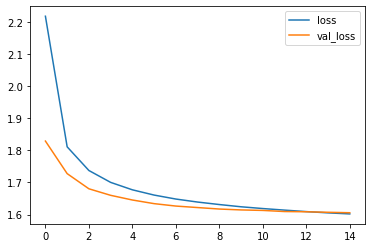

In [34]:

from tensorflow.keras.optimizers import Adam

lstm_model = model_lstm(Embedding_Matrix)
lstm_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

generator = data_generator(Train_Captions, Train_Encodes, wordtoix, max_length, number_pics_per_batch)
val_generator = data_generator(Validation_Captions, Validation_Encodes, wordtoix, max_length, number_pics_per_batch)
hist = lstm_model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1, validation_data=val_generator, validation_steps=val_steps)
lstm_model.save('v2_lstmweights.h5')





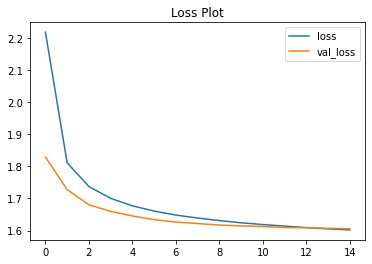

In [35]:


import matplotlib.pyplot as plt

loss = hist.history['loss']
val_loss = hist.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss', 'val_loss'])
plt.title('Loss Plot')
plt.show()

## Train Bidirectional LSTM with Trainable Embedding Matrix

In [215]:

from tensorflow.keras.optimizers import Adam

trainable_bilstm_model = trainable_bilstm(Embedding_Matrix)
trainable_bilstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

generator = data_generator(Train_Captions, Train_Encodes, wordtoix, max_length, number_pics_per_batch)
val_generator = data_generator(Validation_Captions, Validation_Encodes, wordtoix, max_length, number_pics_per_batch)
hist_trainable_bilstm = trainable_bilstm_model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1, validation_data=val_generator, validation_steps=val_steps)
trainable_bilstm_model.save('v3_trainable_bilstm.h5')





Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 17)]         0           []                               
                                                                                                  
 input_15 (InputLayer)          [(None, 1536)]       0           []                               
                                                                                                  
 embedding_7 (Embedding)        (None, 17, 200)      200800      ['input_16[0][0]']               
                                                                                                  
 dropout_14 (Dropout)           (None, 1536)         0           ['input_15[0][0]']               
                                                                                            

KeyboardInterrupt: 

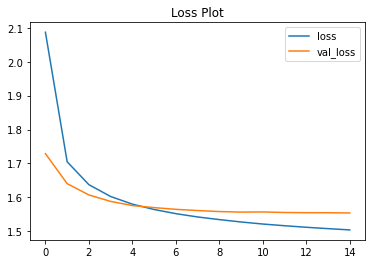

In [38]:


import matplotlib.pyplot as plt

loss = hist_trainable_bilstm.history['loss']
val_loss = hist_trainable_bilstm.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss', 'val_loss'])
plt.title('Loss Plot')
plt.show()

## Train Bidirectional GRU with Non-Trainable Embedding Matrix

In [40]:

from tensorflow.keras.optimizers import Adam

biGRU_model = model_biGru(Embedding_Matrix)
biGRU_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

generator = data_generator(Train_Captions, Train_Encodes, wordtoix, max_length, number_pics_per_batch)
val_generator = data_generator(Validation_Captions, Validation_Encodes, wordtoix, max_length, number_pics_per_batch)
hist_biGRU_model = biGRU_model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1, validation_data=val_generator, validation_steps=val_steps)
biGRU_model.save('v2_biGRU.h5')





Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 17)]         0           []                               
                                                                                                  
 input_21 (InputLayer)          [(None, 1536)]       0           []                               
                                                                                                  
 embedding_10 (Embedding)       (None, 17, 200)      200800      ['input_22[0][0]']               
                                                                                                  
 dropout_20 (Dropout)           (None, 1536)         0           ['input_21[0][0]']               
                                                                                           

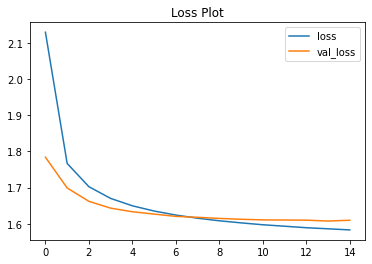

In [41]:


import matplotlib.pyplot as plt

loss = hist_biGRU_model.history['loss']
val_loss = hist_biGRU_model.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss', 'val_loss'])
plt.title('Loss Plot')
plt.show()

In [ ]:
import numpy as np
from tensorflow.keras.optimizers import Adam

bilstm_model = model_bilstm(Embedding_Matrix)

bilstm_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

for i in range(epochs):
    generator = data_generator(Train_Captions, Train_Encodes, wordtoix, max_length, number_pics_per_batch)
    bilstm_model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
bilstm_model.save('bilstmweights.h5')

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 17)]         0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 1536)]       0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 17, 200)      200800      ['input_8[0][0]']                
                                                                                                  
 dropout_6 (Dropout)            (None, 1536)         0           ['input_7[0][0]']                
                                                                                            

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
gru_model = model_gru(Embedding_Matrix)

gru_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

for i in range(epochs):
    generator = data_generator(Train_Captions, Train_Encodes, wordtoix, max_length, number_pics_per_batch)
    gru_model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
gru_model.save('gruweights.h5')

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 17)]         0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 1536)]       0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 17, 200)      200800      ['input_8[0][0]']                
                                                                                                  
 dropout_6 (Dropout)            (None, 1536)         0           ['input_7[0][0]']                
                                                                                            

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
bigru_model = model_biGru(Embedding_Matrix)

bigru_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

for i in range(epochs):
    generator = data_generator(Train_Captions, Train_Encodes, wordtoix, max_length, number_pics_per_batch)
    bigru_model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
bigru_model.save('bigruweights.h5')

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 17)]         0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 1536)]       0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 17, 200)      200800      ['input_8[0][0]']                
                                                                                                  
 dropout_6 (Dropout)            (None, 1536)         0           ['input_7[0][0]']                
                                                                                            

## Test Image Encoding

In this section, we start encoding the test images just as we did the same for train dataset.

In [ ]:
model_test=Feature_Extraction_Model() #ResNetv2 Model for Test Image

In [17]:
os.chdir('C:\\Users\\ataka\\Desktop\\EEE443_Proje') #Change Accordingly

def Test_Dataset_Read(file_train):
    '''
    Funtction to read given h5 train file
    '''
    f = h5py.File(file_train, 'r') #Load Data
    print("Keys: %s" % list(f.keys()))
    test_cap = f['test_caps'][()] #Captions for training images (contains 17 indices from the vocabulary for each image
    test_imid = f['test_imid'][()] #The indices of training images (since a single image can be captioned several times
    test_url = f['test_url'][()] #Flickr URLs for training images 

    test_ims = None  #Do not use train_ims. Otherwise, score is halved!!
    print("Size of captions: ",test_cap.shape)
    print("Size of indices of test images: ",test_imid.shape[0])
    print("Size of URL: ",test_url.shape[0])

    return test_imid, test_cap, test_url 

test_imid,test_cap,test_url=Test_Dataset_Read(file_test)


Keys: ['test_caps', 'test_imid', 'test_ims', 'test_url']
Size of captions:  (195954, 17)
Size of indices of test images:  195954
Size of URL:  40504


In [ ]:
Test_dir = direc + '\\Test_Ims'
model_test.summary()

## New Functions for Test Dataset Encoding:

Below, you will find modified versions of the encoding functions. Normally, when you download the files from URL, your file type should not be specificly stated. If it is already stated as JPEG. You might want to use the modified functions below. Otherwise, original functions might create some problems. Since this was a direct JPEG file, I have deleted the PNG files manually. Thus, modified functions were needed. Sorry for the lousy coding practice. 

In [18]:
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.preprocessing import image 
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

def TESTImageEncoding(directory, imageIndex,model):
    #Process images so that they can be inputted in the model correctly.
    img = tf.io.read_file(directory+imageIndex)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.expand_dims(img, axis=0)
    #print(img.shape)
    img = preprocess_input(img)
    with tf.device("/cpu:0"): #BE CAREFUL, IF YOU USE GPU, THERE WILL BE MEMORY LEAK!!
        encoding = model.predict(img) #Extracts features into single 2D vector.
    return encoding    #Should be of size (1,1536)


def Create_TEST_Features(directory,model):
    os.chdir('C:\\Users\\ataka\\Desktop\\EEE443_Proje')#Change accordingly
    os.chdir(directory) #Change to Test directory!
    print(os.getcwd())#Check
    Encoded_Features = []
    for img in tqdm(os.listdir()): #Scans the directory. img is a string!
        tmp = TESTImageEncoding(os.getcwd()+ '\\',img, model)
        Encoded_Features.append(tmp)

    Encoded_Features=np.array(Encoded_Features)
    Encoded_Features=Encoded_Features.reshape(Encoded_Features.shape[0],Encoded_Features.shape[2])
    return Encoded_Features #Should output (x,1536) where x is the number of samples.


In [ ]:
Encoded_TEST_Features=Create_TEST_Features(Test_dir,model_test) #Will take some time! Progress bar gives a better estimate of the current state of the fucntion.

In [19]:
import pickle #Call the function in case you have not!


In [ ]:
os.chdir(Test_dir)
Index_TEST=[]
for img in tqdm(os.listdir()): #Scans the directory. img is a string!
            Index_TEST.append(img) #Index is used for storing the current index order of the encoded dataset!

In [ ]:
print('Encoding finished for Test Dataset. Pickling.')
if not os.path.exists(exports_dir): #Create the directory if it does not exist in the first place.
        os.makedirs(exports_dir)
os.chdir(exports_dir)
print(os.getcwd())#Check

# save to file
print(Encoded_TEST_Features.shape)#Checking the shape
pickle.dump(Encoded_TEST_Features, open('TEST_Feature_Encodes.pkl', 'wb'))
pickle.dump(Index_TEST, open('TEST_Feature_Index.pkl', 'wb'))


os.chdir(direc) # return back to the main directory
print(os.getcwd())#Check

## Check whether the file is saved correctly by loading it again.

In [18]:
print(os.getcwd())
os.chdir(exports_dir)
print(os.getcwd())

C:\Users\ataka\Desktop\EEE443_Proje
C:\Users\ataka\Desktop\EEE443_Proje\Exported_Ims


In [21]:
TEST_Encodes = pickle.load(open(exports_dir + "\\TEST_Feature_Encodes.pkl",'rb'), encoding='utf8')
TEST_Index = pickle.load(open(exports_dir + "\\TEST_Feature_Index.pkl",'rb'), encoding='utf8')
print(TEST_Encodes.shape)
TEST_Index=np.array(TEST_Index)
print(TEST_Index.shape)

(22481, 1536)
(22481,)


# Test Encodes and Captions files

In [ ]:
TEST_Feature_Dictionary= dict(zip(TEST_Index, TEST_Encodes)) #We create dictionary from the encoded files (index,features)
import random
import math
def Test_Prep(percentage, list_to_divide):
    indices = random.sample(list(list_to_divide.keys()), len(list_to_divide)- math.ceil((1-percentage)*len(list_to_divide)))
    Test = {}
    indices = [x[:-4] for x in indices]
    results = list(map(int, indices)) #Convert From String to Int for sorting
    results.sort(reverse=False) #Ascending Order
    for idx in results:
            Test[str(idx)]=(list_to_divide[str(idx)+'.jpg'])
    return Test
Test=Test_Prep(1.0, TEST_Feature_Dictionary)


from tqdm.notebook import tqdm #For progress bar representation. Purely decoration purposes!
#from tqdm import tqdm #For progress bar representation

#With this dataset, we will call our previous functions for captioning.
def TestDataPreparation(imid, cap, KEY_Lists,  encoding_dict , word_dict):
    ENCODES = []
    CAPTIONS = []
    for key in tqdm(list(KEY_Lists.keys())): 
        key_captions = Fetch_Caption(key, imid, cap, word_dict)
        # Replicate encoding number of caption times.
        for i in range(len(key_captions)):
            ENCODES.append(encoding_dict[key+'.jpg']) #Iterate for number of captions
        
        # Process the captions:
        for c in key_captions:
            CAPTIONS.append(c)
            
    return ENCODES,CAPTIONS

In [ ]:
Test_Encode, Test_Caption = TestDataPreparation(test_imid, test_cap, Test, TEST_Feature_Dictionary, wordDict)

### Saving the Outputs:
Now that we have processed the test data, we can proceed to save them in pickle file format so that they can be called in the future without any compilation.

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
import pickle #Call the function
os.chdir(exports_dir)
print(os.getcwd())

# save to file
pickle.dump(Test_Encode, open('Test_Encodes.pkl', 'wb'))
pickle.dump(Test_Caption, open('Test_Captions.pkl', 'wb'))


os.chdir(direc) # return back to the main directory

In [ ]:
print('Test Encode Shape:',np.array(Test_Encode).shape)
print('Test Caption Shape:',np.array(Test_Caption).shape)

In [236]:
import pickle #Call the function
os.chdir(exports_dir)
Test_Encodes = pickle.load(open('TEST_Feature_Encodes.pkl', 'rb'))
Test_Index = pickle.load(open('TEST_Feature_Index.pkl', 'rb'))
Test_Index=np.array([Test_Index]).T
print(Test_Index.shape)
print(Test_Encodes.shape)

(22481, 1)
(22481, 1536)


In [244]:
def Caption_GET(caps, word_dict):
    i = 0
    text_cap = []
    
    for item in caps:
        temp = []
        for word in item:
            key=get_key(word,word_dict)
            temp.append(key)
        text_cap.append(temp)
        # x_NULL_ strings are only ignored, not erased from the captions
    Captions_list = Caption_string(text_cap)

    return Captions_list 


def Caption_GENERATE(caps, word_dict):
    temp = []
    Captions_list=[]
    for word in caps:
            key=get_key(word,word_dict)
            temp.append(key)
        # x_NULL_ strings are only ignored, not erased from the captions
    caption = ""    
    for word in temp:
            if (word == 'x_NULL_') or (word == 'x_START_') or (word == 'x_END_'):
                continue #Don't count x_NULL, x_Start and x_END
            elif (word == 'x_UNK_'):
                word = 'UNKNOWN'
            caption += word + " "

    Captions_list.append(caption.strip()) #Remove spaces and append
    return Captions_list







### BLEU Score Implementation

In [245]:

def GenerateBatch(Test_Index, Test_Encodes,wordtoix, model,batch_size=281):
    ''' 
        Create Batches and Evaluate BLEU score
    '''
    actual_container={}
    pred_container={}
    TestDataset=tf.data.Dataset.from_tensor_slices((Test_Encodes,Test_Index))
    for batch in TestDataset.batch(255):
            feats = batch[0].numpy() #Indexes
            iteration = feats.shape[0]
            seq = np.tile(np.array([1] + [0]*16), (iteration, 1))
            for i in range(16):
                with tf.device("/cpu:0"): #BE CAREFUL, IF YOU USE GPU, THERE WILL BE MEMORY LEAK!!
                    pred = model.predict([feats, seq])
                seq[:, i+1] = np.argmax(pred, axis=1)
            for i in range(iteration):
                name = batch[1].numpy()[i][0].decode()
                #!!! If your keys are '.jpg' then do this. Otherwise, comment
                #nameID=int(name[:-4])
                pred_container[name] = Caption_GENERATE(seq[i],wordtoix)

    for d in TestDataset.take(Test_Encodes.shape[0]):
            name = d[1].numpy()[0].decode()
            nameID=int(name[:-4])
            cap=Fetch_Caption(nameID, test_imid, test_cap, wordtoix)
            actual_container[name] = Caption_GET(cap,wordtoix)  
    return actual_container, pred_container  

In [318]:
from keras.models import load_model
os.chdir(direc)
model = load_model("v2_bilstm.h5")
actual_container, pred_container= GenerateBatch(Test_Index, Test_Encodes,wordDict, model,batch_size=281)

In [319]:
import pickle #Call the function
os.chdir(exports_dir)
print(os.getcwd())

# save to file
#pickle.dump(actual_container, open('actual_container.pkl', 'wb'))
#pickle.dump(pred_container, open('pred_container_v2_trainable_bilstm.pkl', 'wb'))
# save to file
#pickle.dump(actual_container, open('actual_container.pkl', 'wb'))
#pickle.dump(pred_container, open('pred_container_v2_lstmweights.pkl', 'wb'))
#pickle.dump(pred_container, open('pred_container_v2_biGRU.pkl', 'wb'))
#pickle.dump(pred_container, open('pred_container_v2_gru.pkl', 'wb'))
#pickle.dump(pred_container, open('pred_container_v2_trainablebiGru.pkl', 'wb'))
pickle.dump(pred_container, open('pred_container_v2_bilstm.pkl', 'wb'))

C:\Users\ataka\Desktop\EEE443_Proje\Exported_Ims


In [320]:
actual_container = pickle.load(open('actual_container.pkl', 'rb'))
pred_container_v2_trainable_bilstm = pickle.load(open('pred_container_v2_trainable_bilstm.pkl', 'rb'))
pred_container_v2_lstmweights = pickle.load(open('pred_container_v2_lstmweights.pkl', 'rb'))
pred_container_v2_biGRU=pickle.load(open('pred_container_v2_biGRU.pkl', 'rb'))
pred_container_v2_gru=pickle.load(open('pred_container_v2_gru.pkl', 'rb'))
pred_container_v2_trainablebiGru=pickle.load(open('pred_container_v2_trainablebiGru.pkl', 'rb'))
pred_container_v2_bilstm=pickle.load(open('pred_container_v2_bilstm.pkl', 'rb'))

In [321]:
print(pred_container_v2_trainable_bilstm['1178.jpg'])
print(pred_container_v2_lstmweights['1178.jpg'])
print(pred_container_v2_biGRU['1178.jpg'])
print(pred_container_v2_gru['1178.jpg'])
print(pred_container_v2_trainablebiGru['1178.jpg'])
print(pred_container_v2_bilstm['1178.jpg'])

print('============')
print(actual_container['1178.jpg'])


['a large UNKNOWN flying through a blue sky']
['a UNKNOWN UNKNOWN plane flying through the air']
['a large UNKNOWN flying through a blue sky']
['a UNKNOWN UNKNOWN plane flying over a UNKNOWN']
['a large UNKNOWN flying through a blue sky']
['a large UNKNOWN flying through the air over a lake']
['a red grey and white airplane UNKNOWN overhead', 'a view from the ground of the bottom of an airplane', 'a jet airplane is flying through the sky', 'the UNKNOWN of a passenger UNKNOWN taking off', 'there is a small plane that is flying in the sky']


# Test Image Captioning

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
os.chdir("/content/drive/MyDrive/EE443 Project/Exported_Ims")
Test_Encodes = pickle.load(open('TEST_Feature_Encodes.pkl', 'rb'))
Test_Index = pickle.load(open('TEST_Feature_Index.pkl', 'rb'))

In [49]:
os.chdir(direc)

wordtoix=pickle.load(open('wordtoix.pkl', 'rb'))
#(wordtoix)

ixtoword=pickle.load(open('ixtoword.pkl', 'rb'))
#(ixtoword)

{0: 'x_NULL_',
 1: 'x_START_',
 2: 'x_END_',
 3: 'x_UNK_',
 4: 'a',
 5: 'on',
 6: 'of',
 7: 'the',
 8: 'in',
 9: 'with',
 10: 'and',
 11: 'is',
 12: 'man',
 13: 'to',
 14: 'sitting',
 15: 'an',
 16: 'two',
 17: 'standing',
 18: 'at',
 19: 'people',
 20: 'are',
 21: 'next',
 22: 'white',
 23: 'woman',
 24: 'table',
 25: 'street',
 26: 'that',
 27: 'holding',
 28: 'person',
 29: 'large',
 30: 'some',
 31: 'it',
 32: 'down',
 33: 'top',
 34: 'group',
 35: 'field',
 36: 'up',
 37: 'small',
 38: 'near',
 39: 'tennis',
 40: 'his',
 41: 'front',
 42: 'black',
 43: 'plate',
 44: 'room',
 45: 'train',
 46: 'riding',
 47: 'dog',
 48: 'red',
 49: 'young',
 50: 'by',
 51: 'cat',
 52: 'water',
 53: 'baseball',
 54: 'has',
 55: 'xWhile',
 56: 'walking',
 57: 'playing',
 58: 'bathroom',
 59: 'sign',
 60: 'blue',
 61: 'food',
 62: 'kitchen',
 63: 'grass',
 64: 'bus',
 65: 'there',
 66: 'parked',
 67: 'pizza',
 68: 'green',
 69: 'side',
 70: 'other',
 71: 'building',
 72: 'looking',
 73: 'snow',
 74: '

In [68]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def generateCaption(photo, wordtoix, ixtoword, model):
    input = 'x_START_'
    photo = photo.reshape(l, 1536)
    sequence = np.zeros((1, 17))
    sequence[:,0] = 1
    for i in range(16):
        yhat = model.predict([photo,sequence], verbose = 0)
        yhat = np.argmax(yhat)
        sequence[:, i+1] = yhat
        word = ixtoword[yhat]
        input += ' ' + word
        if word == 'x_END_':
            break
    final = input.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [ ]:
import pickle
import matplotlib.pyplot as plt
from keras.models import load_model
os.chdir("/content/drive/MyDrive/EE443 Project")
model = load_model("gruweights.h5")
test_img_dir = "/content/drive/MyDrive/EE443 Project/Test_Ims"
sample_img = "/31"
Image.open(test_img_dir+sample_img, mode = 'r')
Captions_list = generateCaption(Test_Encodes[69], wordtoix, wordDict, model)
print(Captions_list)

a man riding a bike on the side of a road


# Bidirectional LSTM Predictions

In [69]:
import pickle
import matplotlib.pyplot as plt
from keras.models import load_model
os.chdir("/content/drive/MyDrive/EE443 Project")
model2 = load_model("bilstmweights.h5")
def caption_testImg(id, model):
  Captions_list = generateCaption(Test_Encodes[id], wordtoix, wordDict, model)
  img_dir = Test_Index[id].split(".")[0]
  im = Image.open(test_img_dir+"/"+img_dir, mode = 'r')
  plt.figure(figsize=(8,8))
  plt.imshow(im)
  plt.axis('off')
  print("Prediction:", Captions_list)
  real_caps = Fetch_Caption(img_dir, test_imid, test_caps, wordtoix)
  print("Actual:")
  Caption_Print(real_caps, wordtoix)

Prediction: a x_UNK_ x_UNK_ jet flying through the sky
Actual:
Caption  1 :  a UNKNOWN UNKNOWN airplane flying in a blue sky
Caption  2 :  a small air plane flying UNKNOWN the air
Caption  3 :  a small airplane flying through a light blue sky
Caption  4 :  there is an old plane flying in the sky
Caption  5 :  a yellow and black fighter plane flying in blue sky


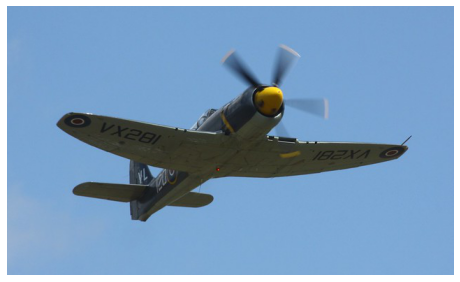

In [ ]:
caption_testImg(139, model2)

Prediction: a bathroom with a sink and a mirror
Actual:
Caption  1 :  that tub is UNKNOWN one UNKNOWN in a UNKNOWN home
Caption  2 :  a bathroom with a large bathtub toilet sink mirror and a large clock
Caption  3 :  inside bathroom with a large clock face on the mirror
Caption  4 :  a bath room with a sink a toilet and a bath tub
Caption  5 :  a bathroom with a tub toilet and a sink


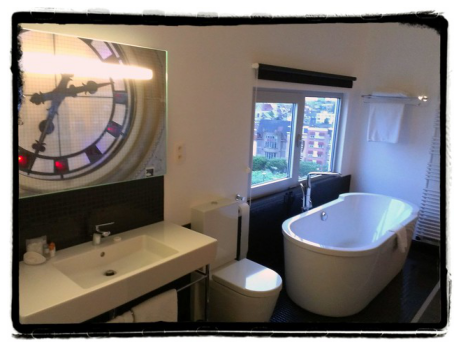

In [ ]:
caption_testImg(79, model2)

Prediction: a man in a suit and tie standing in front of a x_UNK_
Actual:
Caption  1 :  a group of people sitting side by side to take a photograph
Caption  2 :  a black and white photo of a group of people in UNKNOWN UNKNOWN
Caption  3 :  a big group people that are posing xFor a picture
Caption  4 :  a UNKNOWN of men and woman wearing UNKNOWN clothing
Caption  5 :  a black and white picture of a group of people


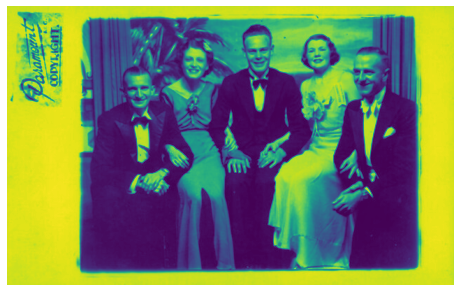

In [ ]:
caption_testImg(159, model2)

Prediction: a zebra standing in a field next to a tree
Actual:
Caption  1 :  a field with various UNKNOWN and trees in the background
Caption  2 :  a group of zebras in a field by some trees
Caption  3 :  the group of zebras are in the field
Caption  4 :  zebras and UNKNOWN UNKNOWN living together on the UNKNOWN
Caption  5 :  many animals in a field with trees and bushes in the background


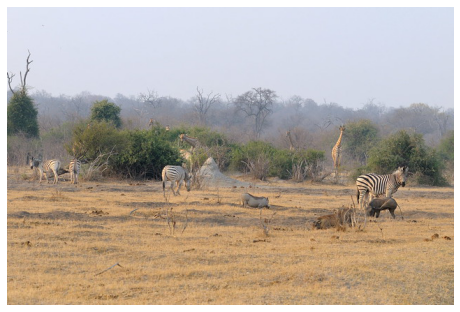

In [ ]:
caption_testImg(179, model2)

Prediction: a giraffe standing in a field next to a tree
Actual:
Caption  1 :  a giraffe grazing from UNKNOWN next to the road
Caption  2 :  a giraffe standing at a dirt road eating off a tree branch
Caption  3 :  a giraffe standing next to a tree eating its leaves
Caption  4 :  this is a tall giraffe standing outside among the trees
Caption  5 :  a giraffe grazing from a tree next to a road


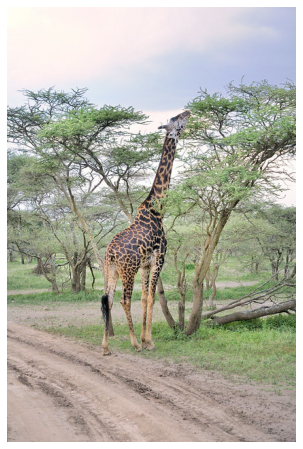

In [ ]:
caption_testImg(219, model2)

Prediction: a man in a suit and tie standing in front of a x_UNK_
Actual:
Caption  1 :  an old black and white photo of two men in suits
Caption  2 :  two men are UNKNOWN wearing suits in this UNKNOWN photo
Caption  3 :  a black and white photo of two young UNKNOWN next to each other
Caption  4 :  a man standing leaning on a man sitting
Caption  5 :  an old black and white photo of two men next to UNKNOWN


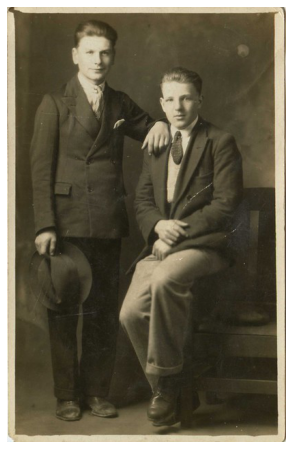

In [ ]:
caption_testImg(339, model2)

Prediction: a man and a woman are standing in a room
Actual:
Caption  1 :  a group of people that are standing up drinking something
Caption  2 :  dressed up people drink at a UNKNOWN UNKNOWN
Caption  3 :  two people holding a glass and smiling at the camera and one man looking UNKNOWN
Caption  4 :  a woman with a drinking glass standing near two men


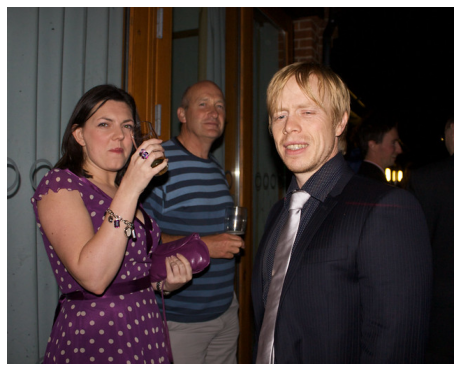

In [ ]:
caption_testImg(1809, model2)

# GRU Predictions

In [ ]:
model = load_model("gruweights.h5")

Prediction: a man riding a bike on the side of a road
Actual:
Caption  1 :  a man in white shirt on bicycle with a dog riding in the back
Caption  2 :  a man on a bicycle with a dog sitting in the back of the bike
Caption  3 :  an old photo of a person on a bike in a parking lot
Caption  4 :  a man and his dog riding on a bike
Caption  5 :  there is a man riding a bike with a dog on the back


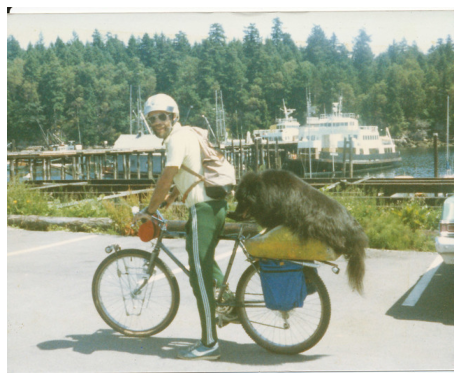

In [ ]:
caption_testImg(69, model)

Prediction: a train is on the tracks near a x_UNK_
Actual:
Caption  1 :  a train moving along a track during the day
Caption  2 :  a train UNKNOWN by a road on a railroad track
Caption  3 :  yellow train engine UNKNOWN UNKNOWN cars past a UNKNOWN crossing
Caption  4 :  a large long train on a steel track
Caption  5 :  a yellow train engine pulling train cars over road


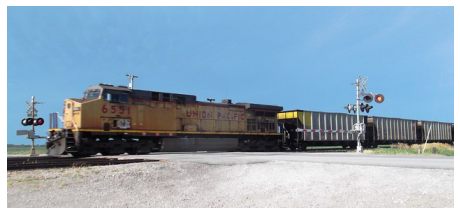

In [ ]:
caption_testImg(259, model)

# Bidirectional LSTM with trained embedding matrix

Prediction: a bird is standing on a x_UNK_ x_UNK_
Actual:
Caption  1 :  two birds sitting on a branch in the woods
Caption  2 :  two small birds perched on tree UNKNOWN together
Caption  3 :  two grey birds sitting on a brown UNKNOWN
Caption  4 :  two small birds perched on two tree UNKNOWN
Caption  5 :  two small birds are resting on a tree branch


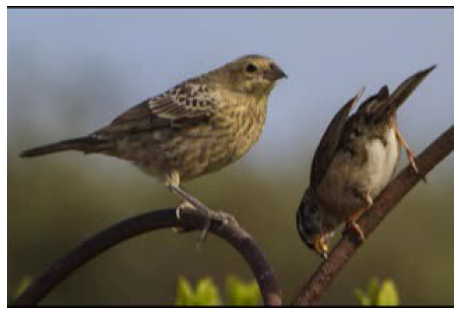

In [ ]:
model3 = load_model("trainablebilstm.h5")
caption_testImg(459, model3)

Prediction: a man riding a horse in a x_UNK_
Actual:
Caption  1 :  a person riding a UNKNOWN and horse down the street
Caption  2 :  a small horse pulling a two UNKNOWN UNKNOWN
Caption  3 :  a house pulling a cart with UNKNOWN on it
Caption  4 :  a horse is pulling a carriage in the street
Caption  5 :  a horse UNKNOWN an UNKNOWN carriage on a UNKNOWN road


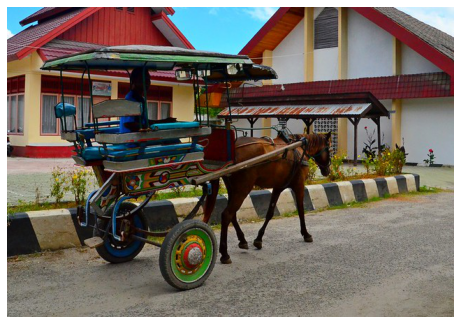

In [ ]:
caption_testImg(1075, model3)